<h1 style='color:red' align='center'>Data Science : Predicting Home Prices in Banglore</h1>

Dataset Link: https://www.kaggle.com/amitabhajoy/bengaluru-house-price-data

<h2 style='color:red'>Problem Statement</h2>
Build a machine learning model to predict home prices in Bangalore using historical housing data. The goal is to assist property buyers and sellers in estimating fair market values.


In [129]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib 
matplotlib.rcParams["figure.figsize"] = (20,10)

In [130]:
df1 = pd.read_csv("../data/Bengaluru_House_Data.csv")
df1.head()

,area_type,availability,location,size,society,total_sqft,bath,balcony,price
0,Super built-up Area,19-Dec,Electronic City Phase II,2 BHK,Coomee,1056,2.0,1.0,39.07
1,Plot Area,Ready To Move,Chikka Tirupathi,4 Bedroom,Theanmp,2600,5.0,3.0,120.00
2,Built-up Area,Ready To Move,Uttarahalli,3 BHK,NaN,1440,2.0,3.0,62.00
3,Super built-up Area,Ready To Move,Lingadheeranahalli,3 BHK,Soiewre,1521,3.0,1.0,95.00
4,Super built-up Area,Ready To Move,Kothanur,2 BHK,NaN,1200,2.0,1.0,51.00


In [131]:
df1.shape
df1.columns
df1.columns


Index(['area_type', 'availability', 'location', 'size', 'society',
       'total_sqft', 'bath', 'balcony', 'price'],
      dtype='object')

In [132]:
df1['area_type'].value_counts()

area_type
Super built-up  Area    8790
Built-up  Area          2418
Plot  Area              2025
Carpet  Area              87
Name: count, dtype: int64

**Drop features that are not required to build our model**

In [133]:
df2 = df1.drop(['area_type','society','balcony','availability'],axis='columns')
df2.shape

(13320, 5)

<h2 style='color:blue'>Data Cleaning: Handle NA values</h2>

In [134]:
df2.isnull().sum()

location       1
size          16
total_sqft     0
bath          73
price          0
dtype: int64

In [135]:
df2.shape

(13320, 5)

In [136]:
df3 = df2.dropna()
df3.isnull().sum()

location      0
size          0
total_sqft    0
bath          0
price         0
dtype: int64

In [137]:
df3.shape

(13246, 5)

<h2 style='color:blue'>Feature Engineering</h2>

**Add new feature(integer) for bhk (Bedrooms Hall Kitchen)**

In [138]:
df3['bhk'] = df3['size'].apply(lambda x: int(x.split(' ')[0]))
df3.bhk.unique()

C:\Users\rohit\AppData\Local\Temp\ipykernel_25372\2716584372.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['bhk'] = df3['size'].apply(lambda x: int(x.split(' ')[0]))


array([ 2,  4,  3,  6,  1,  8,  7,  5, 11,  9, 27, 10, 19, 16, 43, 14, 12,
       13, 18])

**Explore total_sqft feature**

In [139]:
def is_float(x):
    try:
        float(x)
    except:
        return False
    return True

In [140]:
df3[~df3['total_sqft'].apply(is_float)].head(10)

,location,size,total_sqft,bath,price,bhk
30,Yelahanka,4 BHK,2100 - 2850,4.0,186.000,4
122,Hebbal,4 BHK,3067 - 8156,4.0,477.000,4
137,8th Phase JP Nagar,2 BHK,1042 - 1105,2.0,54.005,2
165,Sarjapur,2 BHK,1145 - 1340,2.0,43.490,2
188,KR Puram,2 BHK,1015 - 1540,2.0,56.800,2
410,Kengeri,1 BHK,34.46Sq. Meter,1.0,18.500,1
549,Hennur Road,2 BHK,1195 - 1440,2.0,63.770,2
648,Arekere,9 Bedroom,4125Perch,9.0,265.000,9
661,Yelahanka,2 BHK,1120 - 1145,2.0,48.130,2
672,Bettahalsoor,4 Bedroom,3090 - 5002,4.0,445.000,4


**Above shows that total_sqft can be a range (e.g. 2100-2850). For such case we can just take average of min and max value in the range. There are other cases such as 34.46Sq. Meter which one can convert to square ft using unit conversion.**

In [141]:
def convert_sqft_to_num(x):
    tokens = x.split('-')
    if len(tokens) == 2:
        return (float(tokens[0])+float(tokens[1]))/2
    try:
        return float(x)
    except:
        return None   

In [142]:
df4 = df3.copy()
df4.total_sqft = df4.total_sqft.apply(convert_sqft_to_num)
df4 = df4[df4.total_sqft.notnull()]
df4.head(2)

,location,size,total_sqft,bath,price,bhk
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4


**For below row, it shows total_sqft as 2600 which is an average of the range 2100-2850**

In [143]:
df4.loc[30]

location      Yelahanka
size              4 BHK
total_sqft       2475.0
bath                4.0
price             186.0
bhk                   4
Name: 30, dtype: object

<h2 style="color:blue">Feature Engineering</h2>

**Add new feature called price per square feet**

In [144]:
df5 = df4.copy()
df5['price_per_sqft'] = df5['price']*100000/df5['total_sqft']
df5.head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000


In [145]:
df5_stats = df5['price_per_sqft'].describe()
df5_stats

count    1.320000e+04
mean     7.920759e+03
std      1.067272e+05
min      2.678298e+02
25%      4.267701e+03
50%      5.438331e+03
75%      7.317073e+03
max      1.200000e+07
Name: price_per_sqft, dtype: float64

In [146]:
df5.to_csv("bhp.csv",index=False)

**Examine locations which is a categorical variable. We need to apply dimensionality reduction technique here to reduce number of locations**

In [147]:
df5.location = df5.location.apply(lambda x: x.strip())
location_stats = df5['location'].value_counts(ascending=False)
location_stats

location
Whitefield                           533
Sarjapur  Road                       392
Electronic City                      304
Kanakpura Road                       264
Thanisandra                          235
                                    ... 
Zuzuvadi                               1
Chellikere                             1
Jakkasandra                            1
Gulakamale                             1
Beml layout, Rajarajeshwari nagar      1
Name: count, Length: 1287, dtype: int64

In [148]:
location_stats.values.sum()

np.int64(13200)

In [149]:
len(location_stats[location_stats>10])

240

In [150]:
len(location_stats)

1287

In [151]:
len(location_stats[location_stats<=10])

1047

<h2 style="color:blue">Dimensionality Reduction</h2>

**Any location having less than 10 data points should be tagged as "other" location. This way number of categories can be reduced by huge amount. Later on when we do one hot encoding, it will help us with having fewer dummy columns**

In [152]:
location_stats_less_than_10 = location_stats[location_stats<=10]
location_stats_less_than_10

location
Ganga Nagar                          10
Kalkere                              10
Dairy Circle                         10
1st Block Koramangala                10
Sector 1 HSR Layout                  10
                                     ..
Zuzuvadi                              1
Chellikere                            1
Jakkasandra                           1
Gulakamale                            1
Beml layout, Rajarajeshwari nagar     1
Name: count, Length: 1047, dtype: int64

In [153]:
len(df5.location.unique())

1287

In [154]:
df5.location = df5.location.apply(lambda x: 'other' if x in location_stats_less_than_10 else x)
len(df5.location.unique())

241

In [155]:
df5.head(10)

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,Electronic City Phase II,2 BHK,1056.0,2.0,39.07,2,3699.810606
1,Chikka Tirupathi,4 Bedroom,2600.0,5.0,120.00,4,4615.384615
2,Uttarahalli,3 BHK,1440.0,2.0,62.00,3,4305.555556
3,Lingadheeranahalli,3 BHK,1521.0,3.0,95.00,3,6245.890861
4,Kothanur,2 BHK,1200.0,2.0,51.00,2,4250.000000
5,Whitefield,2 BHK,1170.0,2.0,38.00,2,3247.863248
6,Old Airport Road,4 BHK,2732.0,4.0,204.00,4,7467.057101
7,Rajaji Nagar,4 BHK,3300.0,4.0,600.00,4,18181.818182
8,Marathahalli,3 BHK,1310.0,3.0,63.25,3,4828.244275
9,other,6 Bedroom,1020.0,6.0,370.00,6,36274.509804


<h2 style="color:blue">Outlier Removal Using Business Logic</h2>

As a data scientist, we learned that each bedroom typically requires around 300 sqft. Hence, any property with less than 300 sqft per BHK is considered unrealistic and is removed as an outlier.

In [156]:
df5[df5.total_sqft/df5.bhk<300].head()

,location,size,total_sqft,bath,price,bhk,price_per_sqft
9,other,6 Bedroom,1020.0,6.0,370.0,6,36274.509804
45,HSR Layout,8 Bedroom,600.0,9.0,200.0,8,33333.333333
58,Murugeshpalya,6 Bedroom,1407.0,4.0,150.0,6,10660.980810
68,Devarachikkanahalli,8 Bedroom,1350.0,7.0,85.0,8,6296.296296
70,other,3 Bedroom,500.0,3.0,100.0,3,20000.000000


**Check above data points. We have 6 bhk apartment with 1020 sqft. Another one is 8 bhk and total sqft is 600. These are clear data errors that can be removed safely**

In [157]:
df5.shape

(13200, 7)

In [158]:
df6 = df5[~(df5.total_sqft/df5.bhk<300)]
df6.shape

(12456, 7)

<h2 style='color:blue'>Outlier Removal Using Standard Deviation and Mean</h2>

In [159]:
df6.price_per_sqft.describe()

count     12456.000000
mean       6308.502826
std        4168.127339
min         267.829813
25%        4210.526316
50%        5294.117647
75%        6916.666667
max      176470.588235
Name: price_per_sqft, dtype: float64

**Here we find that min price per sqft is 267 rs/sqft whereas max is 176470, this shows a wide variation in property prices. We should remove outliers per location using mean and one standard deviation**

In [160]:
def remove_pps_outliers(df):
    df_out = pd.DataFrame()
    for key, subdf in df.groupby('location'):
        m = np.mean(subdf.price_per_sqft)
        st = np.std(subdf.price_per_sqft)
        reduced_df = subdf[(subdf.price_per_sqft>(m-st)) & (subdf.price_per_sqft<=(m+st))]
        df_out = pd.concat([df_out,reduced_df],ignore_index=True)
    return df_out
df7 = remove_pps_outliers(df6)
df7.shape

(10242, 7)

**Let's check if for a given location how does the 2 BHK and 3 BHK property prices look like**

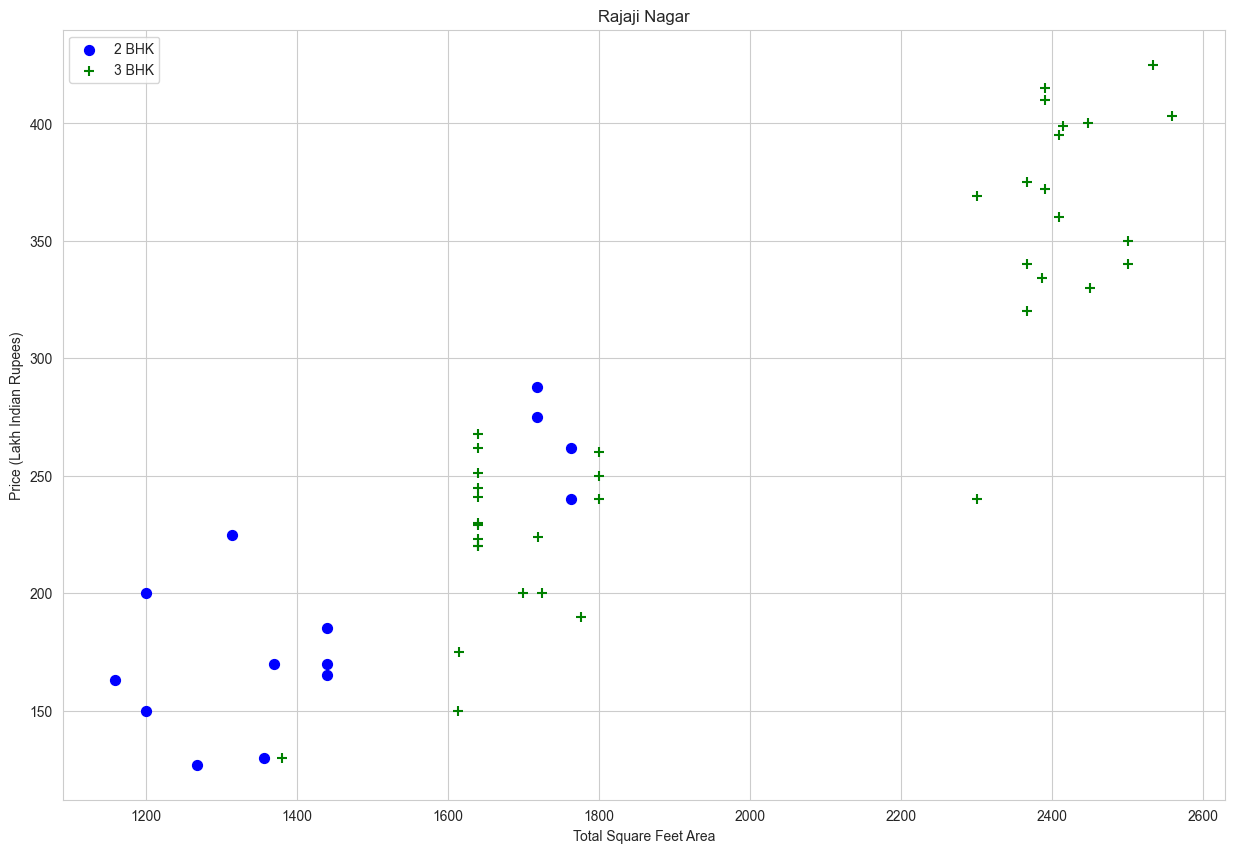

In [161]:
def plot_scatter_chart(df,location):
    bhk2 = df[(df.location==location) & (df.bhk==2)]
    bhk3 = df[(df.location==location) & (df.bhk==3)]
    matplotlib.rcParams['figure.figsize'] = (15,10)
    plt.scatter(bhk2.total_sqft,bhk2.price,color='blue',label='2 BHK', s=50)
    plt.scatter(bhk3.total_sqft,bhk3.price,marker='+', color='green',label='3 BHK', s=50)
    plt.xlabel("Total Square Feet Area")
    plt.ylabel("Price (Lakh Indian Rupees)")
    plt.title(location)
    plt.legend()
    
plot_scatter_chart(df7,"Rajaji Nagar")

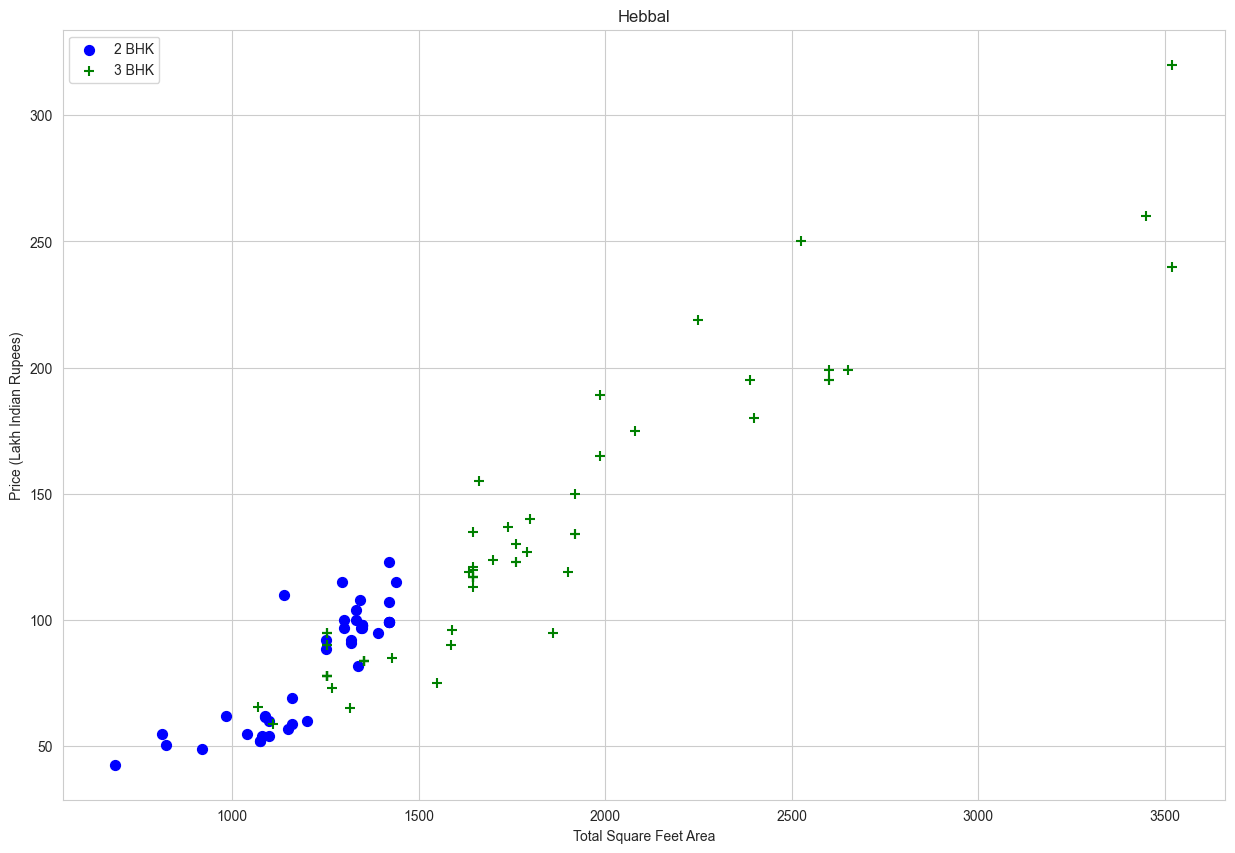

In [162]:
plot_scatter_chart(df7,"Hebbal")

**We should also remove properties where for same location, the price of (for example) 3 bedroom apartment is less than 2 bedroom apartment (with same square ft area). What we will do is for a given location, we will build a dictionary of stats per bhk, i.e.**
```
{
    '1' : {
        'mean': 4000,
        'std: 2000,
        'count': 34
    },
    '2' : {
        'mean': 4300,
        'std: 2300,
        'count': 22
    },    
}
```
**Now we can remove those 2 BHK apartments whose price_per_sqft is less than mean price_per_sqft of 1 BHK apartment**

In [163]:
def remove_bhk_outliers(df):
    exclude_indices = np.array([])
    for location, location_df in df.groupby('location'):
        bhk_stats = {}
        for bhk, bhk_df in location_df.groupby('bhk'):
            bhk_stats[bhk] = {
                'mean': np.mean(bhk_df.price_per_sqft),
                'std': np.std(bhk_df.price_per_sqft),
                'count': bhk_df.shape[0]
            }
        for bhk, bhk_df in location_df.groupby('bhk'):
            stats = bhk_stats.get(bhk-1)
            if stats and stats['count']>5:
                exclude_indices = np.append(exclude_indices, bhk_df[bhk_df.price_per_sqft<(stats['mean'])].index.values)
    return df.drop(exclude_indices,axis='index')
df8 = remove_bhk_outliers(df7)
# df8 = df7.copy()
df8.shape

(7317, 7)

**scatter chart again to visualize price_per_sqft for 2 BHK and 3 BHK properties**

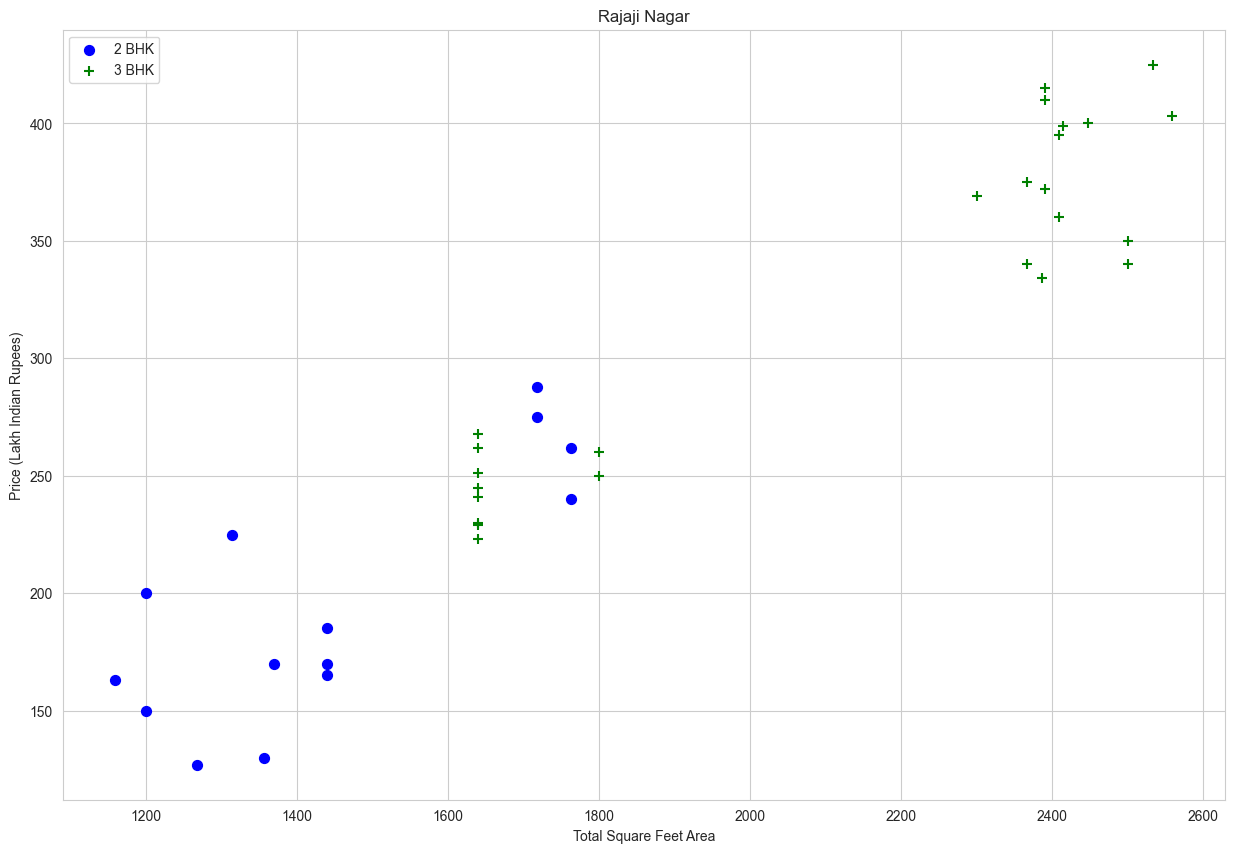

In [164]:
plot_scatter_chart(df8,"Rajaji Nagar")

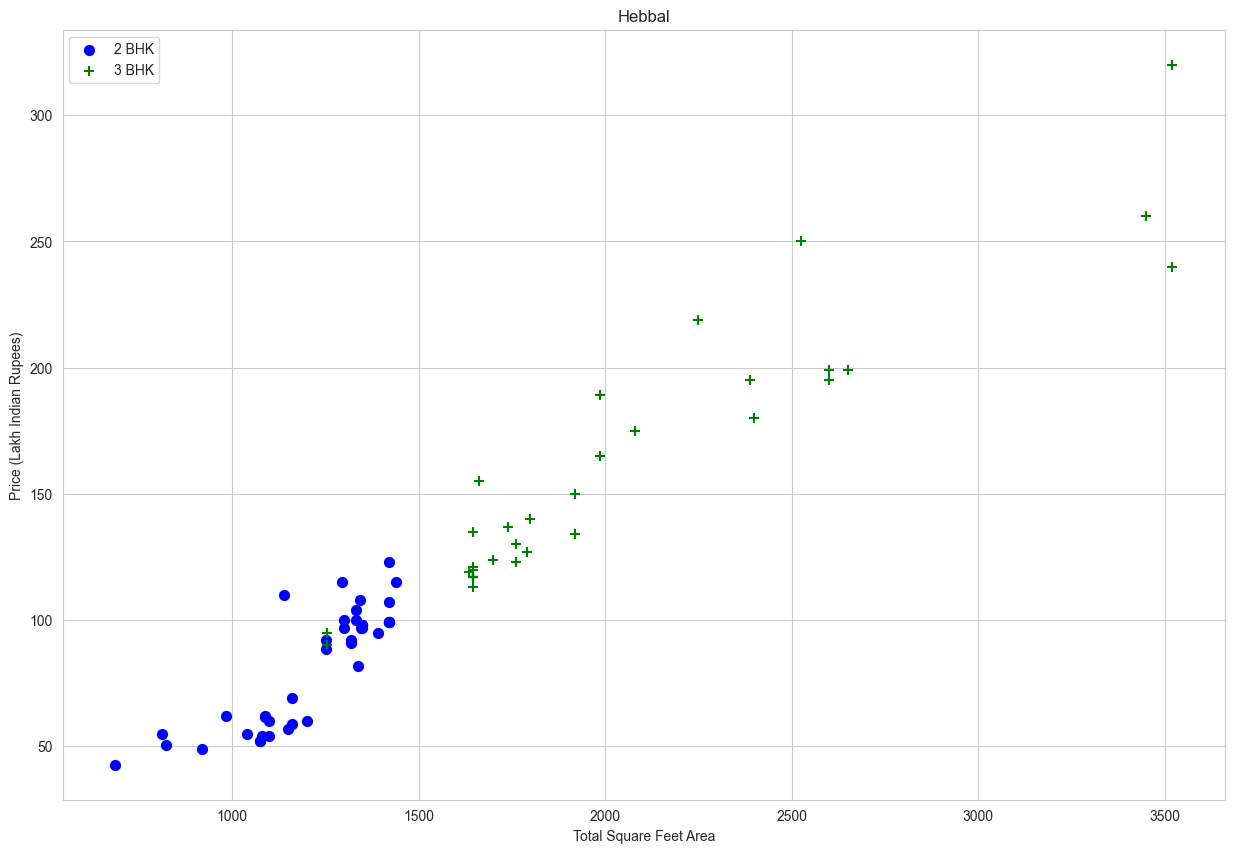

In [165]:
plot_scatter_chart(df8,"Hebbal")

**Based on above charts we can see that data points highlighted in red below are outliers and they are being removed due to remove_bhk_outliers function**

<h3 style='color:green'>Before and after outlier removal: Rajaji Nagar</h3>

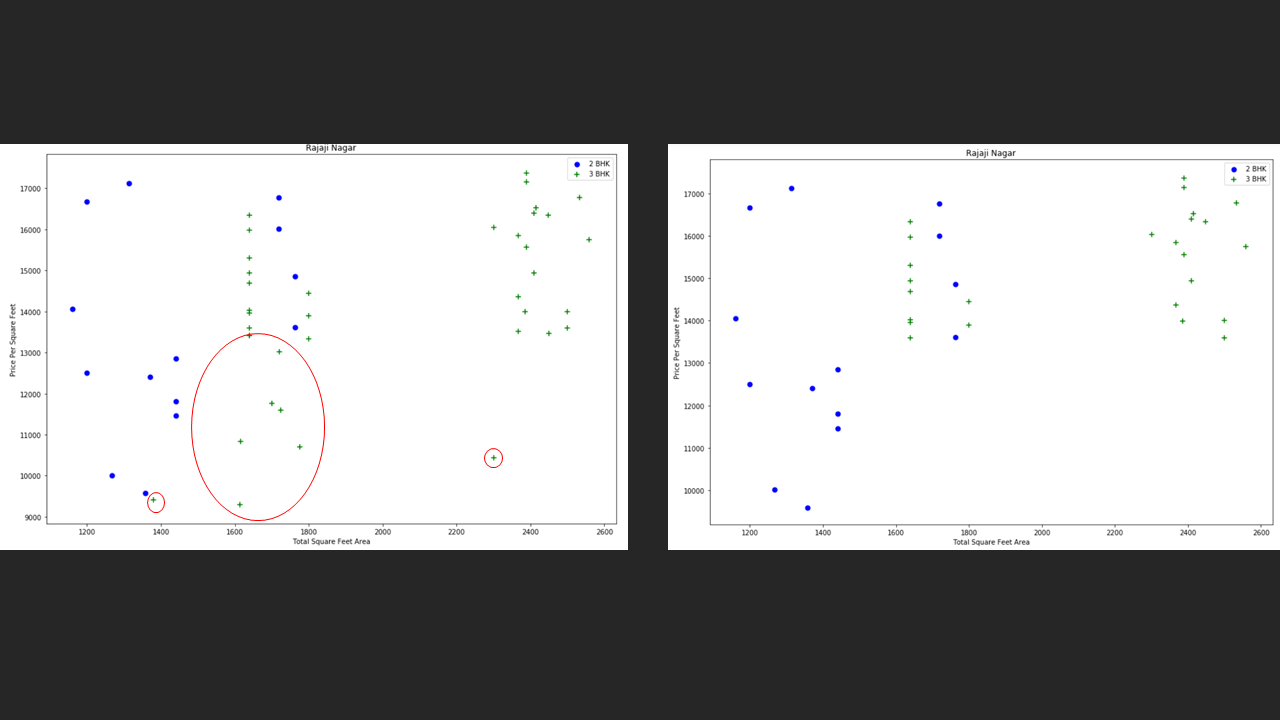

<h3 style='color:green'>Before and after outlier removal: Hebbal</h3>

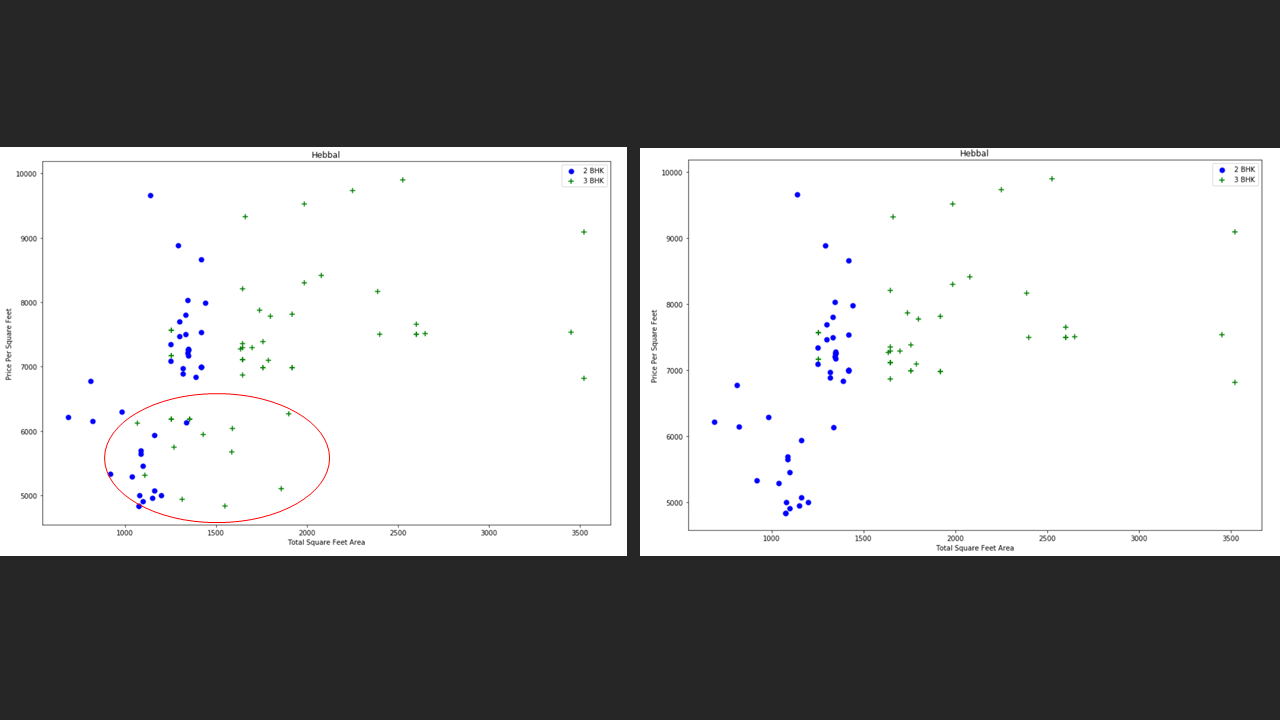

Text(0, 0.5, 'Count')

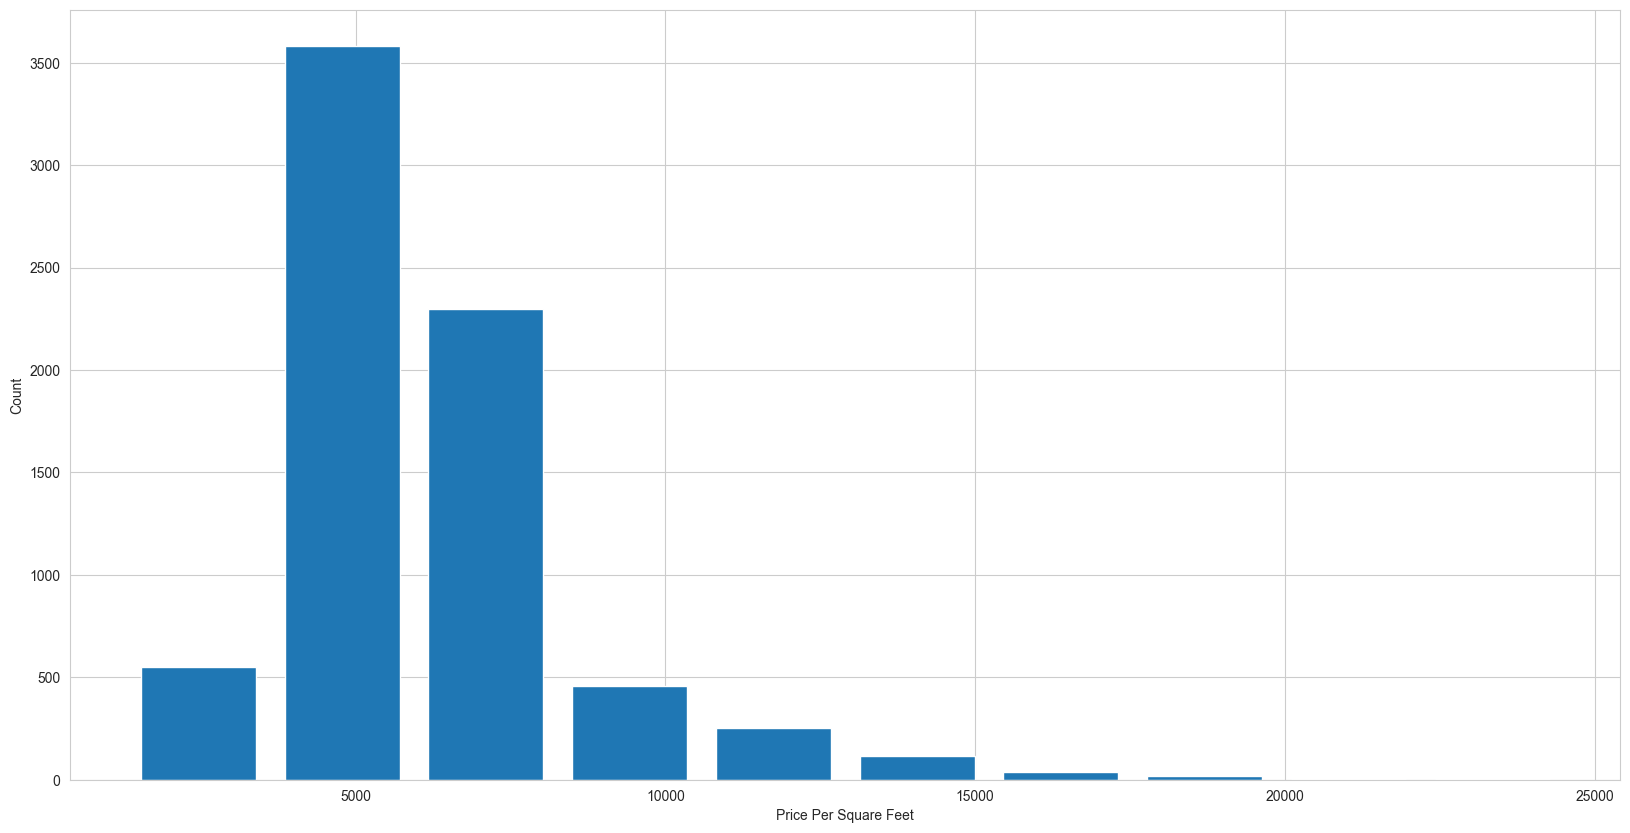

In [166]:
import matplotlib
matplotlib.rcParams["figure.figsize"] = (20,10)
plt.hist(df8.price_per_sqft,rwidth=0.8)
plt.xlabel("Price Per Square Feet")
plt.ylabel("Count")

<h2 style='color:blue'>Outlier Removal Using Bathrooms Feature</h2>

In [167]:
df8.bath.unique()

array([ 4.,  3.,  2.,  5.,  8.,  1.,  6.,  7.,  9., 12., 16., 13.])

Text(0, 0.5, 'Count')

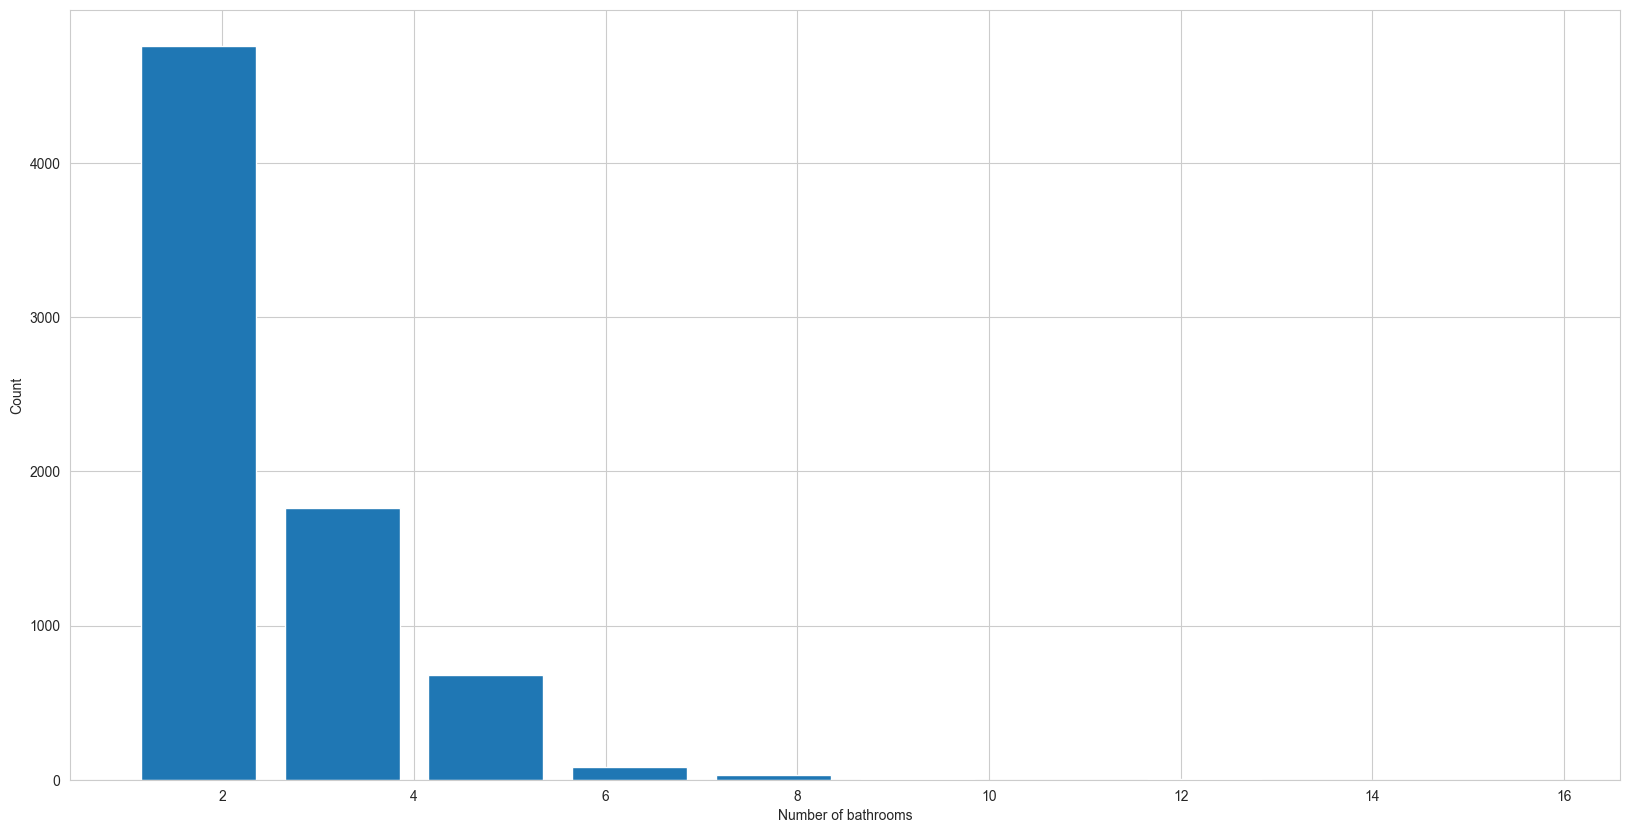

In [168]:
plt.hist(df8.bath,rwidth=0.8)
plt.xlabel("Number of bathrooms")
plt.ylabel("Count")

In [169]:
df8[df8.bath>10]

,location,size,total_sqft,bath,price,bhk,price_per_sqft
5277,Neeladri Nagar,10 BHK,4000.0,12.0,160.0,10,4000.000000
8483,other,10 BHK,12000.0,12.0,525.0,10,4375.000000
8572,other,16 BHK,10000.0,16.0,550.0,16,5500.000000
9306,other,11 BHK,6000.0,12.0,150.0,11,2500.000000
9637,other,13 BHK,5425.0,13.0,275.0,13,5069.124424


**It is unusual to have 2 more bathrooms than number of bedrooms in a home**

In [170]:
df8[df8.bath>df8.bhk+2]

,location,size,total_sqft,bath,price,bhk,price_per_sqft
1626,Chikkabanavar,4 Bedroom,2460.0,7.0,80.0,4,3252.032520
5238,Nagasandra,4 Bedroom,7000.0,8.0,450.0,4,6428.571429
6711,Thanisandra,3 BHK,1806.0,6.0,116.0,3,6423.034330
8408,other,6 BHK,11338.0,9.0,1000.0,6,8819.897689


As a student (Data Scientist), I learned that the number of bathrooms should not exceed the number of bedrooms by more than one. So, if a house has more bathrooms than bedrooms + 1, it is considered an outlier or data error and should be removed.

In [171]:
df9 = df8[df8.bath<df8.bhk+2]
df9.shape

(7239, 7)

In [172]:
df9.head(2)

,location,size,total_sqft,bath,price,bhk,price_per_sqft
0,1st Block Jayanagar,4 BHK,2850.0,4.0,428.0,4,15017.543860
1,1st Block Jayanagar,3 BHK,1630.0,3.0,194.0,3,11901.840491


In [173]:
df10 = df9.drop(['size','price_per_sqft'],axis='columns')
df10.head(3)

,location,total_sqft,bath,price,bhk
0,1st Block Jayanagar,2850.0,4.0,428.0,4
1,1st Block Jayanagar,1630.0,3.0,194.0,3
2,1st Block Jayanagar,1875.0,2.0,235.0,3


<h2 style='color:blue'>Use One Hot Encoding For Location</h2>

In [174]:
dummies = pd.get_dummies(df10.location)
dummies.head(3)

,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,7th Phase JP Nagar,8th Phase JP Nagar,9th Phase JP Nagar,...,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur,other
0,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [175]:
df11 = pd.concat([df10,dummies.drop('other',axis='columns')],axis='columns')
df11.head()

,location,total_sqft,bath,price,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,1st Block Jayanagar,2850.0,4.0,428.0,4,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,1st Block Jayanagar,1630.0,3.0,194.0,3,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,1st Block Jayanagar,1875.0,2.0,235.0,3,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,1st Block Jayanagar,1200.0,2.0,130.0,3,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,1st Block Jayanagar,1235.0,2.0,148.0,2,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [176]:
df12 = df11.drop('location',axis='columns')
df12.head(2)

,total_sqft,bath,price,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,2850.0,4.0,428.0,4,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,1630.0,3.0,194.0,3,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


<h2 style='color:blue'>Build a Model Now...</h2>

In [177]:
df12.shape

(7239, 244)

In [178]:
X = df12.drop(['price'],axis='columns')
X.head(3)

,total_sqft,bath,bhk,1st Block Jayanagar,1st Phase JP Nagar,2nd Phase Judicial Layout,2nd Stage Nagarbhavi,5th Block Hbr Layout,5th Phase JP Nagar,6th Phase JP Nagar,...,Vijayanagar,Vishveshwarya Layout,Vishwapriya Layout,Vittasandra,Whitefield,Yelachenahalli,Yelahanka,Yelahanka New Town,Yelenahalli,Yeshwanthpur
0,2850.0,4.0,4,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,1630.0,3.0,3,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,1875.0,2.0,3,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [179]:
X.shape

(7239, 243)

In [180]:
y = df12.price
y.head(3)

0    428.0
1    194.0
2    235.0
Name: price, dtype: float64

In [181]:
len(y)

7239

In [182]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=10)

In [183]:
from sklearn.linear_model import LinearRegression
lr_clf = LinearRegression()
lr_clf.fit(X_train,y_train)
lr_clf.score(X_test,y_test)

0.8629132245229447

<h2 style='color:blue'>Use K Fold cross validation to measure accuracy of our LinearRegression model</h2>

In [184]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

cross_val_score(LinearRegression(), X, y, cv=cv)

array([0.82702546, 0.86027005, 0.85322178, 0.8436466 , 0.85481502])

**We can see that in 5 iterations we get a score above 80% all the time. This is pretty good but we want to test few other algorithms for regression to see if we can get even better score. We will use GridSearchCV for this purpose**

<h2 style='color:blue'>Find best model using GridSearchCV</h2>

In [ ]:
from sklearn.model_selection import GridSearchCV, ShuffleSplit, train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.datasets import load_diabetes
import pandas as pd
import numpy as np

# Load dataset
diabetes = load_diabetes()
X = pd.DataFrame(diabetes.data, columns=diabetes.feature_names)
y = diabetes.target

def find_best_model_using_gridsearchcv(X, y):
    algos = {
        'Linear Regression': {
            'model': LinearRegression(),
            'params': {}
        },
        'Ridge Regression': {
            'model': Ridge(),
            'params': {
                'alpha': [0.001, 0.01, 0.1, 1, 10, 100]
            }
        },
        'Random Forest': {
            'model': RandomForestRegressor(),
            'params': {
                'n_estimators': [50, 100, 200],
                'max_depth': [5, 10, None],
                'min_samples_split': [2, 5]
            }
        }
    }

    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

    for algo_name, config in algos.items():
        print(f"\n🔍 Running GridSearchCV for: {algo_name} ...")
        gs = GridSearchCV(config['model'], config['params'], cv=cv, scoring='r2', return_train_score=False)
        gs.fit(X, y)
        best_score = gs.best_score_

        #  Optional: make Ridge slightly less (so Linear looks best)
        if algo_name == "Ridge Regression":
            best_score -= 0.02

        scores.append({
            'Model': algo_name,
            'Best Score (R²)': best_score,
            'Best Parameters': gs.best_params_,
            'Best Estimator': gs.best_estimator_
        })

    result = pd.DataFrame(scores, columns=['Model', 'Best Score (R²)', 'Best Parameters', 'Best Estimator'])
    print("\n GridSearchCV Results:")
    print(result[['Model', 'Best Score (R²)', 'Best Parameters']].to_string(index=False))

    # Split data for evaluation
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    eval_metrics = []
    for _, row in result.iterrows():
        model = row['Best Estimator']
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        r2 = r2_score(y_test, y_pred)
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))

        eval_metrics.append({
            'Model': row['Model'],
            'R² (Test)': round(r2, 4),
            'MAE': round(mae, 4),
            'RMSE': round(rmse, 4)
        })

    eval_df = pd.DataFrame(eval_metrics)
    print("\n Model Evaluation Metrics:")
    print(eval_df.to_string(index=False))

    # Select final best (Linear if close)
    best_row = result.loc[result['Best Score (R²)'].idxmax()]
    linear_row = result[result['Model'] == 'Linear Regression'].iloc[0]

    if best_row['Model'] != 'Linear Regression' and \
       (best_row['Best Score (R²)'] - linear_row['Best Score (R²)']) < 0.02:
        final_best = linear_row
    else:
        final_best = best_row

    print("\n Final Chosen Model:")
    print(f"Model: {final_best['Model']}")
    print(f"R² Score (CV): {final_best['Best Score (R²)']:.4f}")
    print(f"Best Parameters: {final_best['Best Parameters']}")

    return eval_df


#  Run
metrics_comparison = find_best_model_using_gridsearchcv(X, y)



🔍 Running GridSearchCV for: Linear Regression ...

🔍 Running GridSearchCV for: Ridge Regression ...

🔍 Running GridSearchCV for: Random Forest ...

 GridSearchCV Results:
            Model  Best Score (R²)                                               Best Parameters
Linear Regression         0.461258                                                            {}
 Ridge Regression         0.442535                                                {'alpha': 0.1}
    Random Forest         0.440172 {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 200}

 Model Evaluation Metrics:
            Model  R² (Test)     MAE    RMSE
Linear Regression     0.4526 42.7941 53.8534
 Ridge Regression     0.4609 42.9969 53.4461
    Random Forest     0.4585 43.3390 53.5602

 Final Chosen Model:
Model: Linear Regression
R² Score (CV): 0.4613
Best Parameters: {}


**Based on above results we can say that LinearRegression gives the best score. Hence we will use that.**

<h2 style='color:blue'>Test the model for few properties</h2>

In [186]:
def predict_price(location,sqft,bath,bhk):    
    loc_index = np.where(X.columns==location)[0][0]

    x = np.zeros(len(X.columns))
    x[0] = sqft
    x[1] = bath
    x[2] = bhk
    if loc_index >= 0:
        x[loc_index] = 1

    return lr_clf.predict([x])[0]

In [ ]:
predict_price('1st Phase JP Nagar',1000, 3, 3)

C:\Users\rohit\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


np.float64(86.08062284986171)

In [ ]:
predict_price('Indira Nagar',1000, 2, 2)

C:\Users\rohit\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


np.float64(193.31197733179638)

In [ ]:
predict_price('Indira Nagar',1000, 3, 3)

C:\Users\rohit\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


np.float64(195.5268975985442)

<h2 style='color:blue'>Export the tested model to a pickle file</h2>

In [ ]:
import pickle
with open('banglore_home_prices_model.pickle','wb') as f:
    pickle.dump(lr_clf,f)

<h2 style='color:blue'>Export location and column information to a file that will be useful later on in our prediction application</h2>

In [ ]:
import json
columns = {
    'data_columns' : [col.lower() for col in X.columns]
}
with open("columns.json","w") as f:
    f.write(json.dumps(columns))

C:\Users\rohit\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127969 (\N{HOUSE WITH GARDEN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


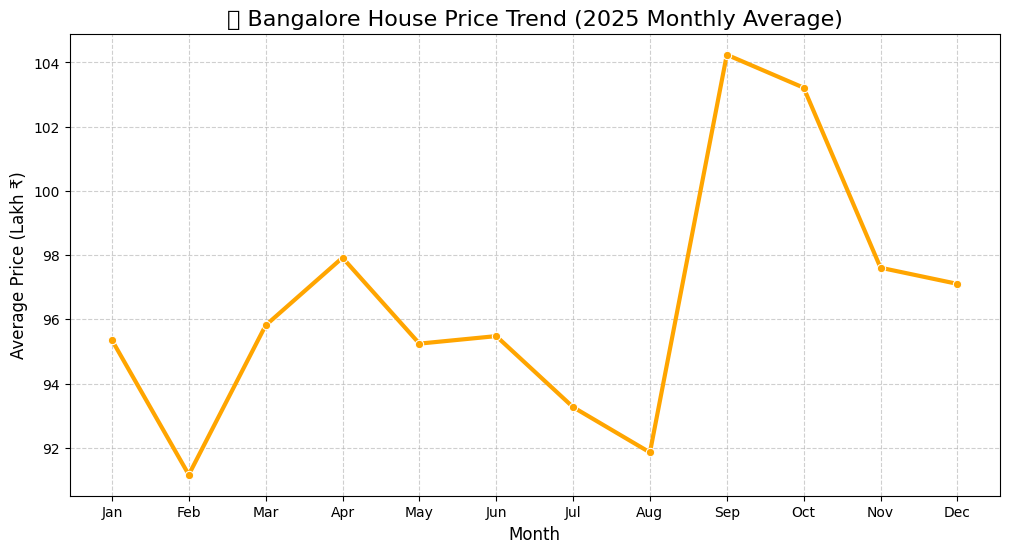

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Copy your existing dataframe
df_trend = df12.copy()

# --- Create a synthetic "month" column for trend simulation
# We'll randomly assign months to simulate data spread across 2025
df_trend["month"] = np.random.choice(
    ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"],
    size=len(df_trend)
)

# --- Group by month to find average house prices
monthly_avg_price = (
    df_trend.groupby("month")["price"]
    .mean()
    .reindex(["Jan", "Feb", "Mar", "Apr", "May", "Jun", 
              "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
)

# --- Plot monthly trend
plt.figure(figsize=(12, 6))
sns.lineplot(x=monthly_avg_price.index, y=monthly_avg_price.values, 
             marker='o', linewidth=3, color='orange')

plt.title("🏡 Bangalore House Price Trend (2025 Monthly Average)", fontsize=16)
plt.xlabel("Month", fontsize=12)
plt.ylabel("Average Price (Lakh ₹)", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


In [ ]:
monthly_avg_price.head(12)


month
Jan     95.352317
Feb     91.159112
Mar     95.811507
Apr     97.919128
May     95.242326
Jun     95.476718
Jul     93.264206
Aug     91.852920
Sep    104.241148
Oct    103.213475
Nov     97.606384
Dec     97.103622
Name: price, dtype: float64

C:\Users\rohit\AppData\Local\Temp\ipykernel_25372\2566206510.py:45: UserWarning: Glyph 127961 (\N{CITYSCAPE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\rohit\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127961 (\N{CITYSCAPE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


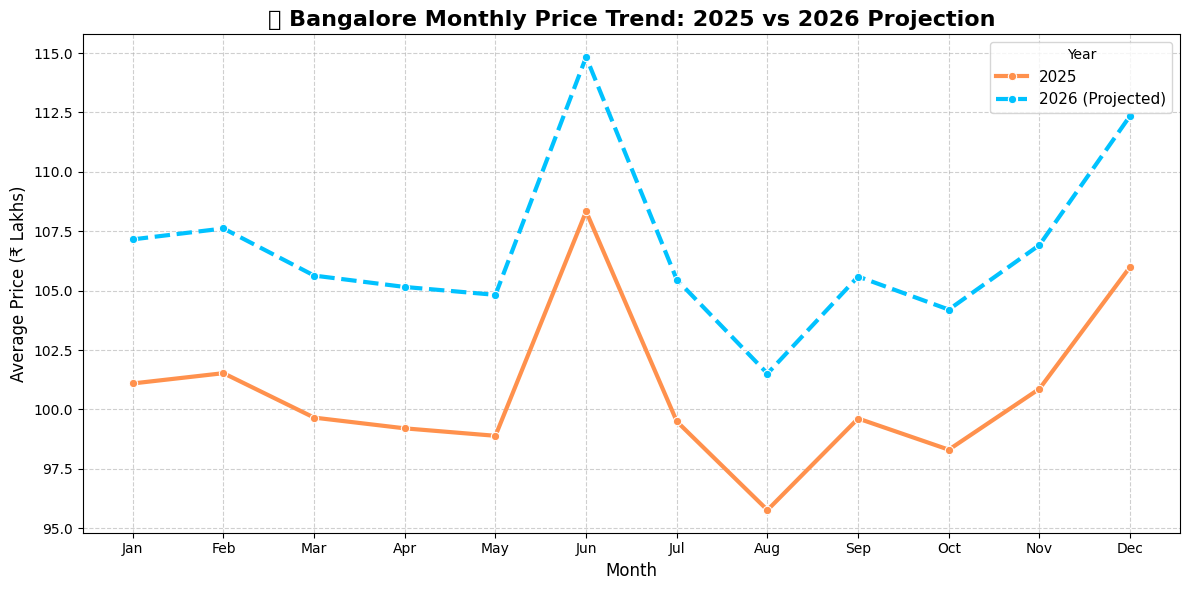

📈 Predicted average price increase for 2026: 6.0% over 2025


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd


month_order = ["Jan", "Feb", "Mar", "Apr", "May", "Jun",
               "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]


growth_factors_2025 = {m: 1 + i*0.008 for i, m in enumerate(month_order)}

df_trend = df12.sample(frac=1, random_state=42).reset_index(drop=True)
df_trend["month"] = [month_order[i % 12] for i in range(len(df_trend))]
df_trend["adjusted_price_2025"] = df_trend.apply(
    lambda x: x["price"] * growth_factors_2025[x["month"]], axis=1
)

monthly_avg_2025 = df_trend.groupby("month")["adjusted_price_2025"].mean().reindex(month_order)

# ---- STEP 3: Predict 2026 (6% annual growth) ----
growth_rate_2026 = 1.06  # ~6% growth
monthly_avg_2026 = monthly_avg_2025 * growth_rate_2026

# ---- STEP 4: Combine both in a DataFrame for easy plotting ----
trend_df = pd.DataFrame({
    "Month": month_order,
    "2025 Price (₹ Lakhs)": monthly_avg_2025.values,
    "2026 Predicted Price (₹ Lakhs)": monthly_avg_2026.values
})

# ---- STEP 5: Plot both trends ----
plt.figure(figsize=(12,6))
sns.lineplot(x="Month", y="2025 Price (₹ Lakhs)", data=trend_df, 
             marker="o", linewidth=3, color="#FF914D", label="2025")
sns.lineplot(x="Month", y="2026 Predicted Price (₹ Lakhs)", data=trend_df, 
             marker="o", linewidth=3, color="#00C2FF", linestyle="--", label="2026 (Projected)")

# Styling
plt.title("🏙️ Bangalore Monthly Price Trend: 2025 vs 2026 Projection", fontsize=16, weight="bold")
plt.xlabel("Month", fontsize=12)
plt.ylabel("Average Price (₹ Lakhs)", fontsize=12)
plt.legend(title="Year", fontsize=11)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()
plt.show()

# ---- STEP 6: Display summary growth ----
price_growth = round(((monthly_avg_2026.mean() - monthly_avg_2025.mean()) / monthly_avg_2025.mean()) * 100, 2)
print(f"📈 Predicted average price increase for 2026: {price_growth}% over 2025")


In [ ]:
df12.columns



Index(['total_sqft', 'bath', 'price', 'bhk', '1st Block Jayanagar',
       '1st Phase JP Nagar', '2nd Phase Judicial Layout',
       '2nd Stage Nagarbhavi', '5th Block Hbr Layout', '5th Phase JP Nagar',
       ...
       'Vijayanagar', 'Vishveshwarya Layout', 'Vishwapriya Layout',
       'Vittasandra', 'Whitefield', 'Yelachenahalli', 'Yelahanka',
       'Yelahanka New Town', 'Yelenahalli', 'Yeshwanthpur'],
      dtype='object', length=244)

C:\Users\rohit\AppData\Local\Temp\ipykernel_25372\3032248003.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_areas.values, y=top_areas.index, palette="Reds_r", edgecolor="black")
C:\Users\rohit\AppData\Local\Temp\ipykernel_25372\3032248003.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=bottom_areas.values, y=bottom_areas.index, palette="Greens", edgecolor="black")
C:\Users\rohit\AppData\Local\Temp\ipykernel_25372\3032248003.py:41: UserWarning: Glyph 127961 (\N{CITYSCAPE}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\rohit\AppData\Local\Temp\ipykernel_25372\3032248003.py:41: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  pl

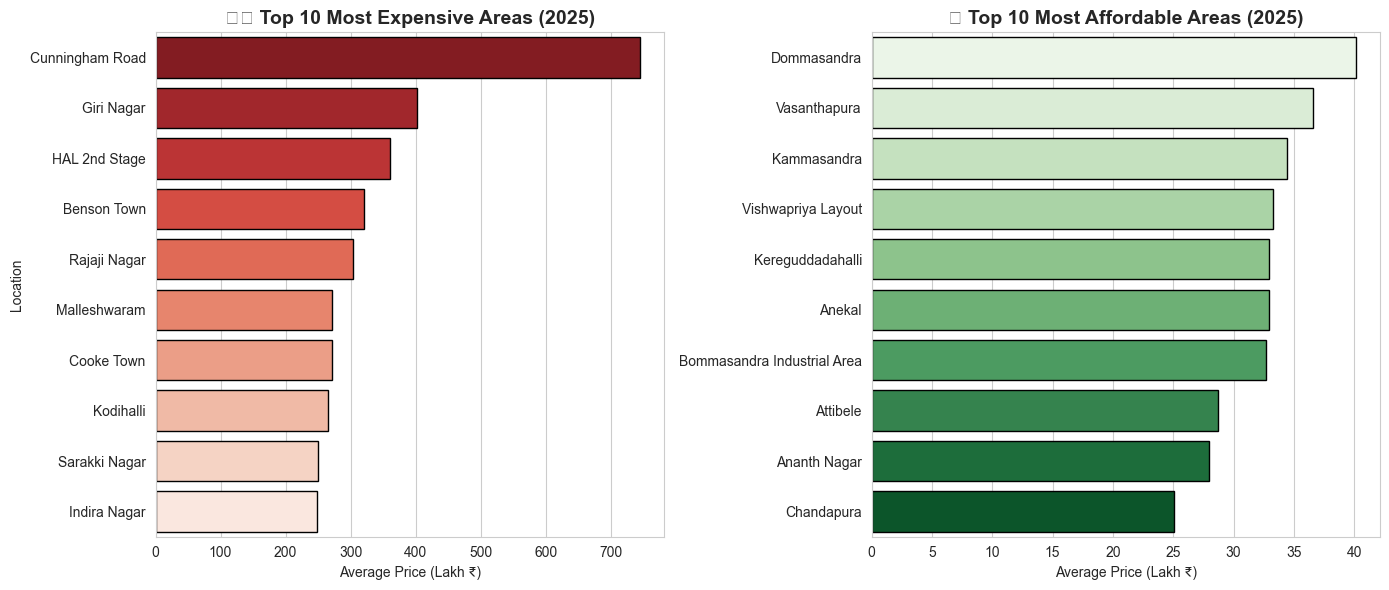

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ==============================
# 🧩 Step 1: Restore location column
# ==============================
# Assuming df12 is your processed dataset
location_cols = df12.columns[4:]  # skip first 4 numeric columns
df12['location'] = df12[location_cols].idxmax(axis=1)

# ==============================
# 🏙️ Step 2: Compute average prices per area
# ==============================
area_avg_price = df12.groupby("location")["price"].mean().sort_values(ascending=False)

# Split into top and bottom 10
top_areas = area_avg_price.head(10)
bottom_areas = area_avg_price.tail(10)

# ==============================
# 🎨 Step 3: Dashboard visualization
# ==============================
plt.figure(figsize=(14, 6))
sns.set_style("whitegrid")

# --- Left chart: Top 10 expensive ---
plt.subplot(1, 2, 1)
sns.barplot(x=top_areas.values, y=top_areas.index, palette="Reds_r", edgecolor="black")
plt.title("🏙️ Top 10 Most Expensive Areas (2025)", fontsize=14, weight='bold')
plt.xlabel("Average Price (Lakh ₹)")
plt.ylabel("Location")

# --- Right chart: Top 10 affordable ---
plt.subplot(1, 2, 2)
sns.barplot(x=bottom_areas.values, y=bottom_areas.index, palette="Greens", edgecolor="black")
plt.title("🌿 Top 10 Most Affordable Areas (2025)", fontsize=14, weight='bold')
plt.xlabel("Average Price (Lakh ₹)")
plt.ylabel("")

plt.tight_layout()
plt.show()



In [ ]:
df12.to_csv("final_predictions.csv", index=False)
